In [1]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.wkt import loads
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import random
from sklearn.linear_model import LinearRegression
import math
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import pyproj
from rasterio.features import Affine
from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import rioxarray
import shapely
import rasterio
import time
from shapely.geometry import mapping
import wget
import os
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
import rasterio
from rasterio.plot import show, show_hist
import rasterstats

/Users/mrwalter/miniforge3/envs/tfm1/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
def ordinal_category(x):
    if x>=100000:
        return 5
    elif x>=10000:
        return 4
    elif x>=1000:
        return 3
    elif x>=100:
        return 2
    elif x>0:
        return 1
    else:
        return 0
    
def isDate(l):
    isDate = False
    for fmt,substr in [('%Y.%m.%d',l[0:10]), ('%Y',l[0:4])]:
        try:
            d = dt.datetime.strptime(substr,fmt).date()
            return True
        except ValueError:
            isDate = False
        return False
    
def get_cal_fire_perimeter_data(monthly=False):
    URL = "https://opendata.arcgis.com/datasets/e3802d2abf8741a187e73a9db49d68fe_2.geojson"
    raw_fire_df = gpd.read_file(URL)
    raw_fire_df['YEAR_'] = pd.to_numeric(raw_fire_df['YEAR_'], downcast='integer', errors = 'coerce')
    fire_summary = raw_fire_df.groupby('YEAR_').sum()
    fire_summary['year'] = fire_summary.index
    fire_summary['acres'] = fire_summary['GIS_ACRES']
    fire_summary['count'] = raw_fire_df.groupby('YEAR_').count()['GIS_ACRES']
    fire_summary = fire_summary[['year', 'acres', 'count']]
    polygon_list, year, start_date, end_date, acres = [], [], [], [], []
    for row in raw_fire_df.to_dict('records'):
            polygons = row['geometry']
            polygons = [polygons] if polygons.geom_type == 'Polygon' else polygons
            for polygon in polygons:
                polygon_list.append(polygon)
                #polygon_coord_list.append([list(list(point) for point in polygon.exterior.coords)])
                year.append(row['YEAR_'])
                start_date.append(row['ALARM_DATE'])
                end_date.append(row['CONT_DATE'])
                acres.append(row['GIS_ACRES'])
    cal_fire_perimeter_df = pd.DataFrame(list(zip(polygon_list, year, start_date, end_date, acres)),
                columns = ['polygon', 'year', 'start_date', 'end_date', 'acres'])
    cal_fire_perimeter_df['year'] = pd.to_numeric(cal_fire_perimeter_df['year'], downcast='integer', errors = 'coerce')              
    cal_fire_perimeter_df['start_date'] = pd.to_datetime(cal_fire_perimeter_df['start_date'], errors = 'coerce', format='%Y/%m/%d')
    cal_fire_perimeter_df['end_date'] = pd.to_datetime(cal_fire_perimeter_df['end_date'], errors = 'coerce', format='%Y/%m/%d')
    cal_fire_perimeter_df['category'] = cal_fire_perimeter_df['acres'].apply(ordinal_category)
    
    if monthly:
        cal_fire_perimeter_df.drop(cal_fire_perimeter_df[(cal_fire_perimeter_df['start_date'].isna())
                                                             & (cal_fire_perimeter_df['end_date'].isna())].index, inplace=True)
        cal_fire_perimeter_df['start_date'] = cal_fire_perimeter_df.apply(lambda row: row['end_date'] if row['start_date'] is pd.NaT
                                                                          else row['start_date'], axis=1)
        cal_fire_perimeter_df['end_date'] = cal_fire_perimeter_df.apply(lambda row: row['start_date'] if row['end_date'] is pd.NaT
                                                                        else row['end_date'], axis=1)
        cal_fire_perimeter_df['start_date'] = cal_fire_perimeter_df.apply(lambda row: row['start_date'] - pd.DateOffset(years=90) if row['start_date'].year == 2106
                                                                        else row['start_date'], axis=1)
        cal_fire_perimeter_df['end_date'] = cal_fire_perimeter_df.apply(lambda row: row['start_date'] if row['start_date']>row['end_date']
                                                                        else row['end_date'], axis=1)
        cal_fire_perimeter_df['duration'] = cal_fire_perimeter_df.apply(lambda row: (row['end_date'] - row['start_date']).days, axis=1)
        
    return cal_fire_perimeter_df, fire_summary

In [3]:
raw_states_boundary_df = gpd.read_file('../Data/cb_2020_us_state_500k/cb_2020_us_state_500k.shp')
california = raw_states_boundary_df.loc[raw_states_boundary_df['STUSPS'] == 'CA']
california_bounds = california.to_crs(epsg=4326).bounds.values.tolist()[0]

daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
california_lcc = california.to_crs(daymet_proj)

In [4]:
fire_df, fire_summary = get_cal_fire_perimeter_data(True)

/var/folders/gb/ndv_p3h970x9bwbwd_0bhhbr0000gp/T/ipykernel_11915/3975875735.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in polygons:


In [6]:
#Creates all years of concern
all_years = []
for year, group in fire_df.groupby('year'):
    all_years.append(year)

In [7]:
def get_vegetation_dates_dictionary():
    dates_list = [name for name in os.listdir('./california_ndvi') if isDate(name)]
    dates_dict = {}
    years = [str(year) for year in range(2001, 2021)]
    months = ['{:02d}'.format(month) for month in range(1, 13)]

    for date in dates_list:
        year, month, day = date[:4], date[5:7], date[8:10]
        next_month = '{:02d}'.format((int(month) % 12) + 1)
        if month == str(12):
            next_year = str(int(year)+1)
        else:
            next_year = year

        if next_year in years:
            if (next_year, next_month) in dates_dict:
                if day > dates_dict[next_year, next_month][8:10]:
                    dates_dict[next_year, next_month] = date
            else:
                dates_dict[next_year, next_month] = date
    return dates_dict

In [8]:
def create_full_dataframe(batch_xr, year, locations, grids, vegetation, vegetation_dates=None):
    
    #Create Predictor Columns
    #========================
    
    #Daymet Data
    batch_df = batch_xr.to_dataframe().dropna().reset_index()
    batch_df['year'] = batch_df['time'].dt.year
    batch_df.drop(columns=['lambert_conformal_conic', 'time'], inplace=True)
    cc = batch_df.groupby(['year', 'x', 'y', 'lon', 'lat']).cumcount() + 1
    batch_df = batch_df.set_index(['year', 'x', 'y', 'lon', 'lat', cc]).unstack()
    batch_df.columns = ['_'.join(map(str,i)) for i in batch_df.columns]
    batch_df.reset_index(inplace=True)
    
    #Vegetation Data
    #===============
    print('')
    if (vegetation):
        vegetation_feature_dict = {}
        months = ['{:02d}'.format(month) for month in range(1, 13)]
        for month in months:
            vegetation_feature_dict = {}
            rf = rasterio.open('california_ndvi/{}/{}.tif'.format(vegetation_dates[str(year), month],vegetation_dates[str(year), month]), mode='r')
            #california_grid = gpd.read_file('california/california_grid.shp')
            ndval = rf.nodatavals[0]
            vegetation_array = rf.read(1)
            affine = rf.transform
            average_vegetation = rasterstats.zonal_stats(grids, vegetation_array, affine=affine, stats=['mean'], nodata=-3000)
            grids['vegetation'] = [location['mean'] for location in average_vegetation]
            grids['vegetation'] = (grids['vegetation'] - (-2000)) / (10000--2000)
            for grid in grids.to_dict('records'):
                vegetation_feature_dict[grid['xy_location']] = grid['vegetation']
#                 for location in locations:
#                     if grid['geometry']==locations[location]:
#                         vegetation_feature_dict[location] = grid['vegetation']
#                         break
            batch_df['vegetation_month_{}'.format(month)] = batch_df.apply(lambda row: vegetation_feature_dict[(row['x'],row['y'])], axis=1)
            print('finished vegetation for month {}'.format(month))

    
    return batch_df

In [9]:
vegetation=True
if vegetation == True:
    years = [year for year in all_years if year >= 2001]
    vegetation_dates_dict = get_vegetation_dates_dictionary()
else:
    years = [year for year in all_years if year >= 1980]
    vegetation_dates_dict = None
    
north = california_bounds[3]
west = california_bounds[0]
east = california_bounds[2]
south = california_bounds[1]
horizontal_stride = 10
vars = ['tmax','tmin','vp','swe','prcp']
region = 'na'

pop_cnt = 0
for year in years:
    batch_cnt = 0
    for var in vars:
        if (var == 'prcp'):
            DAYMET_URL = 'https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1855/daymet_v4_{}_monttl_na_{}.nc?var=lat&var=lon&var={}&north={}&west={}&east={}&south={}&disableProjSubset=on&horizStride={}&time_start={}-01-01T12:00:00Z&time_end={}-12-31T12:00:00Z&timeStride=1&accept=netcdf'.format(var, year, var, north, west, east, south, horizontal_stride, year, year)
        else:
            DAYMET_URL = 'https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1855/daymet_v4_{}_monavg_na_{}.nc?var=lat&var=lon&var={}&north={}&west={}&east={}&south={}&disableProjSubset=on&horizStride={}&time_start={}-01-01T12:00:00Z&time_end={}-12-31T12:00:00Z&timeStride=1&accept=netcdf'.format(var, year, var, north, west, east, south, horizontal_stride, year, year)
        file_name = wget.download(DAYMET_URL)
        ds = xr.open_dataset(file_name)
        os.remove(file_name)
        
        #Only keep locations in California and create locations dictionary
        if (pop_cnt==0) and (batch_cnt==0):
            M = len(ds['lat'])
            N = len(ds['lat'][0])
            california_array = np.ones([len(ds['lat']),len(ds['lat'][0])])
            california_xarray = xr.DataArray(california_array , dims=("y", "x"))
            locations = {}
            locations_list = []
            x_y_locations_list = []
            for i in range(0, M):
                for j in range(0, N):
                    california_array[i][j] = california.geometry.contains(Point(ds['lon'].values[i][j], ds['lat'].values[i][j]))
                    if (i<M-1) and (j<N-1) and california_array[i][j]:
                        locations[ds['x'].values[j], ds['y'].values[i]] = Polygon([[ds['lon'].values[i][j], ds['lat'].values[i][j]],
                                                 [ds['lon'].values[i+1][j], ds['lat'].values[i+1][j]],
                                                 [ds['lon'].values[i+1][j+1], ds['lat'].values[i+1][j+1]],
                                                 [ds['lon'].values[i][j+1], ds['lat'].values[i][j+1]]])
                        locations_list.append(Polygon([[ds['lon'].values[i][j], ds['lat'].values[i][j]],
                                                 [ds['lon'].values[i+1][j], ds['lat'].values[i+1][j]],
                                                 [ds['lon'].values[i+1][j+1], ds['lat'].values[i+1][j+1]],
                                                 [ds['lon'].values[i][j+1], ds['lat'].values[i][j+1]]]))
                        x_y_locations_list.append((ds['x'].values[j], ds['y'].values[i]))
            california_grid_gdf = gpd.GeoDataFrame(geometry=locations_list, crs="EPSG:4326")
            california_grid_gdf['xy_location'] = x_y_locations_list
            #california_grid_gdf.to_file('california_grid.shp')
        
        #Merge variables together
        ds = ds.where(california_xarray==True)
        if batch_cnt == 0:
            batch = ds
        else:
            batch = xr.merge([batch, ds])
        batch_cnt += 1
        
    #Create or append years together
    batch_df = create_full_dataframe(batch, year, locations, california_grid_gdf, vegetation, vegetation_dates_dict)
    if pop_cnt==0:
        population_df = batch_df
    else:
        population_df = pd.concat([population_df, batch_df], ignore_index=True)
    pop_cnt += 1
    print(' year '+str(year)+' done')
    
#Create Labels

100% [............................................................................] 730436 / 730436
finished vegetation for month 01
finished vegetation for month 02
finished vegetation for month 03
finished vegetation for month 04
finished vegetation for month 05
finished vegetation for month 06
finished vegetation for month 07
finished vegetation for month 08
finished vegetation for month 09
finished vegetation for month 10
finished vegetation for month 11
finished vegetation for month 12
 year 2001 done
100% [............................................................................] 730436 / 730436
finished vegetation for month 01
finished vegetation for month 02
finished vegetation for month 03
finished vegetation for month 04
finished vegetation for month 05
finished vegetation for month 06
finished vegetation for month 07
finished vegetation for month 08
finished vegetation for month 09
finished vegetation for month 10
finished vegetation for month 11
finished vegetation for m

In [10]:
population_df.columns

Index(['year', 'x', 'y', 'lon', 'lat', 'tmax_1', 'tmax_2', 'tmax_3', 'tmax_4',
       'tmax_5', 'tmax_6', 'tmax_7', 'tmax_8', 'tmax_9', 'tmax_10', 'tmax_11',
       'tmax_12', 'tmin_1', 'tmin_2', 'tmin_3', 'tmin_4', 'tmin_5', 'tmin_6',
       'tmin_7', 'tmin_8', 'tmin_9', 'tmin_10', 'tmin_11', 'tmin_12', 'vp_1',
       'vp_2', 'vp_3', 'vp_4', 'vp_5', 'vp_6', 'vp_7', 'vp_8', 'vp_9', 'vp_10',
       'vp_11', 'vp_12', 'swe_1', 'swe_2', 'swe_3', 'swe_4', 'swe_5', 'swe_6',
       'swe_7', 'swe_8', 'swe_9', 'swe_10', 'swe_11', 'swe_12', 'prcp_1',
       'prcp_2', 'prcp_3', 'prcp_4', 'prcp_5', 'prcp_6', 'prcp_7', 'prcp_8',
       'prcp_9', 'prcp_10', 'prcp_11', 'prcp_12', 'vegetation_month_01',
       'vegetation_month_02', 'vegetation_month_03', 'vegetation_month_04',
       'vegetation_month_05', 'vegetation_month_06', 'vegetation_month_07',
       'vegetation_month_08', 'vegetation_month_09', 'vegetation_month_10',
       'vegetation_month_11', 'vegetation_month_12'],
      dtype='object')

In [11]:
def yearly_fire_data(population_df, fire_df):
    #Create Fire Label Columns
    #=========================
    wildfire_df = population_df.copy()

    #Determine which locations contain the fire
    all_fire_locations = []
    for fire in fire_df.to_dict('records'):
        fire_locations = []
        for location in locations:
            if fire['polygon'].intersects(locations[location]):
                fire_locations.append(location)
        all_fire_locations.append(fire_locations)
    fire_df['locations'] = all_fire_locations
    fire_df

    #Initialize output dictionary
    output_label = {}
    output_category = {}
    for year in all_years:
        for location in locations:
            output_label[year, location] = 0
            output_category[year, location] = 0

    #Populate output labels
    for fire in fire_df.to_dict('records'):
        for fire_location in fire['locations']:
            if (fire['acres'] > output_label[fire['year'], fire_location]):
                output_label[fire['year'], fire_location] = fire['acres']
                output_category[fire['year'], fire_location] = fire['category']

    wildfire_df['acres'] = wildfire_df.apply(lambda row: output_label[row['year'], (row['x'],row['y'])], axis=1)
    wildfire_df['category'] = wildfire_df.apply(lambda row: output_category[row['year'], (row['x'],row['y'])], axis=1)
    wildfire_df['location'] = wildfire_df.apply(lambda row: locations[row['x'],row['y']], axis=1)

    #Normalizes the fire acres data
    min_fire = wildfire_df['acres'].min()
    max_fire = wildfire_df['acres'].max()
    wildfire_df['scale'] = (wildfire_df['acres'] - min_fire) / (max_fire - min_fire)
    
    #Fire History Feature
    #====================
    one_year_history = []
    five_year_history = []
    ten_year_history = []
    twenty_year_history = []

    for instance in wildfire_df.to_dict('records'):
        one_year_history.append(output_category[instance['year']-1, (instance['x'],instance['y'])])
        five_year_history.append(max(output_category[year, (instance['x'],instance['y'])] for year in range(instance['year']-5, instance['year'])))
        ten_year_history.append(max(output_category[year, (instance['x'],instance['y'])] for year in range(instance['year']-10, instance['year'])))
        twenty_year_history.append(max(output_category[year, (instance['x'],instance['y'])] for year in range(instance['year']-20, instance['year'])))
        
    wildfire_df['1_year_history'] = one_year_history
    wildfire_df['5_year_history'] = five_year_history
    wildfire_df['10_year_history'] = ten_year_history
    wildfire_df['20_year_history'] = twenty_year_history
    
#     wildfire_df.loc[wildfire_df['1_year_history']>0, '1_year_history'] = 1
#     wildfire_df.loc[wildfire_df['5_year_history']>0, '5_year_history'] = 1
#     wildfire_df.loc[wildfire_df['10_year_history']>0, '10_year_history'] = 1
#     wildfire_df.loc[wildfire_df['20_year_history']>0, '20_year_history'] = 1
    
    return wildfire_df

In [12]:
def months_between(start_date, end_date):
    year = start_date.year
    month = start_date.month
    
    months_list = []
    while(year, month) <= (end_date.year, end_date.month):
        months_list.append(dt.date(year, month, 1))
        
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return months_list
    

def monthly_fire_data(population_df, fire_df):
    
    #Convert to Monthly DF
    #=====================
    year_list, month_list, x_list, y_list, lon_list, lat_list = [], [], [], [], [], []
    tmax_list, tmin_list, vp_list, swe_list, prcp_list, vegetation_list = [], [], [], [], [], []
    for row in population_df.to_dict('records'):
        for month in range(1, 13):
            year_list.append(row['year'])
            month_list.append(month)
            x_list.append(row['x'])
            y_list.append(row['y'])
            lon_list.append(row['lon'])
            lat_list.append(row['lat'])
            tmax_list.append(row['tmax_{}'.format(month)])
            tmin_list.append(row['tmin_{}'.format(month)])
            vp_list.append(row['vp_{}'.format(month)])
            swe_list.append(row['swe_{}'.format(month)])
            prcp_list.append(row['prcp_{}'.format(month)])
            vegetation_list.append(row['vegetation_month_{:02d}'.format(month)])
            
    wildfire_df = pd.DataFrame(list(zip(year_list, month_list, x_list, y_list, lon_list, lat_list, tmax_list, tmin_list, vp_list, swe_list, prcp_list, vegetation_list)),
                columns = ['year', 'month', 'x', 'y', 'lon', 'lat', 'tmax', 'tmin', 'vp', 'swe', 'prcp', 'vegetation'])
    
    #==============================================
    #Create Fire Labels and fire history features
    #==============================================
    
    #Determine which locations contain the fire
    all_fire_locations = []
    all_fire_months = []
    for fire in fire_df.to_dict('records'):
        fire_locations = []
        for location in locations:
            if fire['polygon'].intersects(locations[location]):
                fire_locations.append(location)
        all_fire_locations.append(fire_locations)
        all_fire_months.append(months_between(fire['start_date'], fire['end_date']))
    fire_df['locations'] = all_fire_locations
    fire_df['dates'] = all_fire_months
    
    #Initialize output dictionary
    output_label = {}
    output_category = {}
    for year in all_years:
        for month in range(1, 13):
            for location in locations:
                output_label[year, month, location] = 0
                output_category[year, month, location] = 0

    #Populate output labels
    for fire in fire_df.to_dict('records'):
        for fire_date in fire['dates']:
            for fire_location in fire['locations']:
                if fire_date.year in all_years:
                    if (fire['acres'] > output_label[fire_date.year, fire_date.month, fire_location]):
                        output_label[fire_date.year, fire_date.month, fire_location] = fire['acres']
                        output_category[fire_date.year, fire_date.month, fire_location] = fire['category']

    wildfire_df['acres'] = wildfire_df.apply(lambda row: output_label[row['year'], row['month'], (row['x'],row['y'])], axis=1)
    wildfire_df['category'] = wildfire_df.apply(lambda row: output_category[row['year'], row['month'], (row['x'],row['y'])], axis=1)
    wildfire_df['location'] = wildfire_df.apply(lambda row: locations[row['x'],row['y']], axis=1)

    #Normalizes the fire acres data
    min_fire = wildfire_df['acres'].min()
    max_fire = wildfire_df['acres'].max()
    wildfire_df['scale'] = (wildfire_df['acres'] - min_fire) / (max_fire - min_fire)
    
    #Fire History Feature
    #====================
    one_year_history = []
    five_year_history = []
    ten_year_history = []
    twenty_year_history = []

    for instance in wildfire_df.to_dict('records'):
        one_year_history.append(max(output_category[instance['year']-1, month, (instance['x'],instance['y'])] for month in range(1, 13)))
        five_year_history.append(max(output_category[year, month, (instance['x'],instance['y'])] for year in range(instance['year']-5, instance['year']) for month in range(1, 13)))
        ten_year_history.append(max(output_category[year, month, (instance['x'],instance['y'])] for year in range(instance['year']-10, instance['year']) for month in range(1, 13)))
        twenty_year_history.append(max(output_category[year, month, (instance['x'],instance['y'])] for year in range(instance['year']-20, instance['year']) for month in range(1, 13)))
        
    wildfire_df['1_year_history'] = one_year_history
    wildfire_df['5_year_history'] = five_year_history
    wildfire_df['10_year_history'] = ten_year_history
    wildfire_df['20_year_history'] = twenty_year_history
    
    return wildfire_df

In [13]:
wildfire_df = monthly_fire_data(population_df, fire_df)
wildfire_df

,year,month,x,y,lon,lat,tmax,tmin,vp,swe,prcp,vegetation,acres,category,location,scale,1_year_history,5_year_history,10_year_history,20_year_history
0,2001,1,-1942.25,38.0,-124.219872,40.178730,12.547097,5.222581,893.403198,0.0,204.190002,0.879405,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
1,2001,2,-1942.25,38.0,-124.219872,40.178730,11.294286,4.716786,862.440002,0.0,204.919998,0.854459,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
2,2001,3,-1942.25,38.0,-124.219872,40.178730,14.709678,6.734516,992.103210,0.0,72.989998,0.820015,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
3,2001,4,-1942.25,38.0,-124.219872,40.178730,13.413000,5.023334,883.905640,0.0,100.510002,0.849320,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
4,2001,5,-1942.25,38.0,-124.219872,40.178730,20.447420,9.984516,1235.278076,0.0,28.719999,0.829482,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906235,2020,8,-1252.25,-762.0,-114.170769,34.329227,45.645805,28.420322,1548.209717,0.0,0.000000,0.291359,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906236,2020,9,-1252.25,-762.0,-114.170769,34.329227,41.957668,22.780333,1089.722656,0.0,0.000000,0.291136,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906237,2020,10,-1252.25,-762.0,-114.170769,34.329227,35.847420,15.839678,700.292603,0.0,0.000000,0.290580,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906238,2020,11,-1252.25,-762.0,-114.170769,34.329227,26.263334,8.921667,460.159332,0.0,0.000000,0.294397,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0


In [17]:
wildfire_df.to_csv('wildfire_data_vegetation.csv', index=False)

In [339]:
# wildfire_df = yearly_fire_data(population_df, fire_df)

(array([3.000e+00, 3.000e+00, 8.671e+03, 1.400e+03, 4.510e+02, 5.700e+02,
        2.470e+02, 7.200e+01, 1.500e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

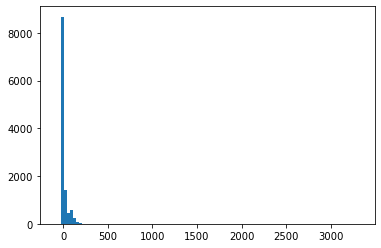

In [225]:
# plt.hist(train_x_resample_df['vegetation_month_06'], bins=100)
plt.hist(fire_df.loc[fire_df['duration']>-100]['duration'], bins=100)

In [31]:
df = pd.read_csv('wildfire_data_vegetation.csv')
df['location'] = df['location'].apply(loads)

In [33]:
df.dtypes

year                 int64
month                int64
x                  float64
y                  float64
lon                float64
lat                float64
tmax               float64
tmin               float64
vp                 float64
swe                float64
prcp               float64
vegetation         float64
acres              float64
category             int64
location            object
scale              float64
1_year_history       int64
5_year_history       int64
10_year_history      int64
20_year_history      int64
dtype: object

## Model Training

In [158]:
prediction_df = wildfire_df.dropna().loc[wildfire_df['year']>=2016][['year', 'x', 'y', 'lon', 'lat','location', 'category']]

In [53]:
wildfire_train_df = wildfire_df.dropna().loc[wildfire_df['year']<2016].drop(columns=['x', 'y','scale', 'acres', 'location'])
wildfire_test_df = wildfire_df.dropna().loc[wildfire_df['year']>=2016].drop(columns=['x', 'y','scale', 'acres', 'location'])

# train_x_resample, train_y_resample = SVMSMOTE().fit_resample(wildfire_train_df.drop(columns='category'), wildfire_train_df['category'])
train_x_resample_df, train_y_resample_df = RandomOverSampler(random_state=20).fit_resample(wildfire_train_df.drop(columns='category'), wildfire_train_df['category'])

test_x_df = wildfire_test_df.drop(columns='category')
test_y_df = wildfire_test_df['category']
train_x_resample_df

,year,lon,lat,tmax_1,tmax_2,tmax_3,tmax_4,tmax_5,tmax_6,tmax_7,...,vegetation_month_07,vegetation_month_08,vegetation_month_09,vegetation_month_10,vegetation_month_11,vegetation_month_12,1_year_history,5_year_history,10_year_history,20_year_history
0,2001,-124.219872,40.178730,12.547097,11.294286,14.709678,13.413000,20.447420,19.080334,20.022259,...,0.833972,0.845800,0.848462,0.864005,0.857312,0.865853,0,0,0,3
1,2001,-124.255119,40.269093,12.904839,11.490357,14.565484,13.285334,19.942581,18.597666,19.559999,...,0.775112,0.786388,0.768778,0.774410,0.773263,0.805255,0,0,0,3
2,2001,-124.290474,40.359447,13.426129,11.937858,14.449355,13.279667,19.320644,18.065332,18.920000,...,0.766934,0.771152,0.750993,0.751821,0.752381,0.792296,0,0,0,3
3,2001,-124.325920,40.449799,13.879678,12.314285,14.267419,13.204333,18.600645,17.450333,18.118710,...,0.758536,0.749468,0.726718,0.725404,0.725481,0.773188,0,0,0,0
4,2001,-124.361473,40.540142,14.435806,12.859285,14.150323,13.237333,17.868387,16.858667,17.141613,...,0.818054,0.797880,0.757788,0.738077,0.732093,0.751868,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309967,2012,-120.220421,40.816380,7.671936,6.290345,8.978387,14.420334,20.260323,23.824333,30.318064,...,0.368659,0.344454,0.320303,0.319865,0.333070,0.345473,0,1,3,3
309968,2009,-118.325668,34.411530,17.413225,14.387143,18.350645,21.033667,28.804838,25.176334,34.454517,...,0.598891,0.572757,0.373729,0.363512,0.376719,0.370892,0,3,3,3
309969,2006,-118.866341,34.693523,13.123549,15.578215,11.439355,15.864000,24.634193,29.761999,33.844517,...,0.527381,0.512963,0.518937,0.439028,0.432599,0.428424,1,2,2,2
309970,2014,-123.119804,41.699768,11.342581,10.630714,14.041935,18.860001,22.533548,27.046333,34.173225,...,0.719755,0.754016,0.725931,0.724718,0.746842,0.738605,0,1,1,1


In [54]:
tmax_cols = ['tmax_{}'.format(i) for i in range(1, 13)]
tmin_cols = ['tmin_{}'.format(i) for i in range(1, 13)]
vp_cols = ['vp_{}'.format(i) for i in range(1, 13)]
swe_cols = ['swe_{}'.format(i) for i in range(1, 13)]
prcp_cols = ['prcp_{}'.format(i) for i in range(1, 13)]
vegetation_cols = ['vegetation_month_{:02d}'.format(i) for i in range(1, 13)]

lon_min = min(train_x_resample_df['lon'].min(), test_x_df['lon'].min())
lon_max = max(train_x_resample_df['lon'].max(), test_x_df['lon'].max())
lat_min = min(train_x_resample_df['lat'].min(), test_x_df['lat'].min())
lat_max = max(train_x_resample_df['lat'].max(), test_x_df['lat'].max())
tmax_min = min(train_x_resample_df[tmax_cols].min().min(), test_x_df[tmax_cols].min().min())
tmax_max = max(train_x_resample_df[tmax_cols].max().max(), test_x_df[tmax_cols].max().max())
tmin_min = min(train_x_resample_df[tmin_cols].min().min(), test_x_df[tmin_cols].min().min())
tmin_max = max(train_x_resample_df[tmin_cols].max().max(), test_x_df[tmin_cols].max().max())
vp_min = min(train_x_resample_df[vp_cols].min().min(), test_x_df[vp_cols].min().min())
vp_max = max(train_x_resample_df[vp_cols].max().max(), test_x_df[vp_cols].max().max())
swe_min = min(train_x_resample_df[swe_cols].min().min(), test_x_df[swe_cols].min().min())
swe_max = max(train_x_resample_df[swe_cols].max().max(), test_x_df[swe_cols].max().max())
prcp_min = min(train_x_resample_df[prcp_cols].min().min(), test_x_df[prcp_cols].min().min())
prcp_max = max(train_x_resample_df[prcp_cols].max().max(), test_x_df[prcp_cols].max().max())
veg_min = min(train_x_resample_df[vegetation_cols].min().min(), test_x_df[vegetation_cols].min().min())
veg_max = max(train_x_resample_df[vegetation_cols].max().max(), test_x_df[vegetation_cols].max().max())
one_year_min = min(train_x_resample_df['1_year_history'].min().min(), test_x_df['1_year_history'].min())
one_year_max = max(train_x_resample_df['1_year_history'].max().max(), test_x_df['1_year_history'].max())
five_year_min = min(train_x_resample_df['5_year_history'].min().min(), test_x_df['5_year_history'].min())
five_year_max = max(train_x_resample_df['5_year_history'].max().max(), test_x_df['5_year_history'].max())
ten_year_min = min(train_x_resample_df['10_year_history'].min().min(), test_x_df['10_year_history'].min())
ten_year_max = max(train_x_resample_df['10_year_history'].max().max(), test_x_df['10_year_history'].max())
twenty_year_min = min(train_x_resample_df['20_year_history'].min().min(), test_x_df['20_year_history'].min())
twenty_year_max = max(train_x_resample_df['20_year_history'].max().max(), test_x_df['20_year_history'].max())

In [95]:
#Predictor Training Data
#=======================
x_train_raw = tf.convert_to_tensor(train_x_resample_df.drop(columns=['year']))
lon_norm = tf.reshape((x_train_raw[:, 0] - lon_min) / (lon_max - lon_min), [-1,1])
lat_norm = tf.reshape((x_train_raw[:, 1] - lat_min) / (lat_max - lat_min), [-1,1])
tmax_norm = (x_train_raw[:,2:14] - tmax_min) / (tmax_max-tmax_min)
tmin_norm = (x_train_raw[:,14:26] - tmin_min) / (tmin_max-tmin_min)
vp_norm = (x_train_raw[:,26:38] - vp_min) / (vp_max-vp_min)
swe_norm = (x_train_raw[:,38:50] - swe_min) / (swe_max-swe_min)
prcp_norm = (x_train_raw[:,50:62] - prcp_min) / (prcp_max-prcp_min)
vegetation_norm = (x_train_raw[:,62:74] - veg_min) / (veg_max-veg_min)
one_year_norm = tf.reshape((x_train_raw[:, 74] - one_year_min) / (one_year_max - one_year_min), [-1,1])
five_year_norm = tf.reshape((x_train_raw[:, 75] - five_year_min) / (five_year_max - five_year_min), [-1,1])
ten_year_norm = tf.reshape((x_train_raw[:, 76] - ten_year_min) / (ten_year_max - ten_year_min), [-1,1])
twenty_year_norm = tf.reshape((x_train_raw[:, 77] - twenty_year_min) / (twenty_year_max - twenty_year_min), [-1,1])
#vegetation_norm = tf.reshape(x_train_raw[:,62], [-1,1])



x_train = tf.concat([lon_norm, lat_norm, tmax_norm, tmin_norm, vp_norm, prcp_norm, vegetation_norm, one_year_norm, five_year_norm, ten_year_norm, twenty_year_norm], 1)
x_train

<tf.Tensor: shape=(309972, 66), dtype=float64, numpy=
array([[0.01389517, 0.8075719 , 0.39656707, ..., 0.        , 0.        ,
        0.6       ],
       [0.01043635, 0.81712987, 0.40247299, ..., 0.        , 0.        ,
        0.6       ],
       [0.00696705, 0.82668704, 0.41107894, ..., 0.        , 0.        ,
        0.6       ],
       ...,
       [0.5392299 , 0.22738162, 0.40608366, ..., 0.4       , 0.4       ,
        0.4       ],
       [0.12184327, 0.96845763, 0.3766818 , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.53673535, 0.2370211 , 0.37234688, ..., 0.6       , 0.6       ,
        0.6       ]])>

In [96]:
#Predictor Testing Data
#======================
x_test_raw = tf.convert_to_tensor(test_x_df.drop(columns=['year']))

lon_norm = tf.reshape((x_test_raw[:, 0] - lon_min) / (lon_max - lon_min), [-1,1])
lat_norm = tf.reshape((x_test_raw[:, 1] - lat_min) / (lat_max - lat_min), [-1,1])
tmax_norm = (x_test_raw[:,2:14] - tmax_min) / (tmax_max-tmax_min)
tmin_norm = (x_test_raw[:,14:26] - tmin_min) / (tmin_max-tmin_min)
vp_norm = (x_test_raw[:,26:38] - vp_min) / (vp_max-vp_min)
swe_norm = (x_test_raw[:,38:50] - swe_min) / (swe_max-swe_min)
prcp_norm = (x_test_raw[:,50:62] - prcp_min) / (prcp_max-prcp_min)
vegetation_norm = (x_test_raw[:,62:74] - veg_min) / (veg_max-veg_min)
one_year_norm = tf.reshape((x_test_raw[:, 74] - one_year_min) / (one_year_max - one_year_min), [-1,1])
five_year_norm = tf.reshape((x_test_raw[:, 75] - five_year_min) / (five_year_max - five_year_min), [-1,1])
ten_year_norm = tf.reshape((x_test_raw[:, 76] - ten_year_min) / (ten_year_max - ten_year_min), [-1,1])
twenty_year_norm = tf.reshape((x_test_raw[:, 77] - twenty_year_min) / (twenty_year_max - twenty_year_min), [-1,1])
#vegetation_norm = tf.reshape(x_test_raw[:,62], [-1,1])

x_test = tf.concat([lon_norm, lat_norm, tmax_norm, tmin_norm, vp_norm, prcp_norm, vegetation_norm, one_year_norm, five_year_norm, ten_year_norm, twenty_year_norm], 1)
x_test

<tf.Tensor: shape=(18879, 66), dtype=float64, numpy=
array([[0.01389517, 0.8075719 , 0.40862389, ..., 0.4       , 0.4       ,
        0.8       ],
       [0.01043635, 0.81712987, 0.41242095, ..., 0.        , 0.        ,
        0.8       ],
       [0.00696705, 0.82668704, 0.41921091, ..., 0.        , 0.4       ,
        0.4       ],
       ...,
       [0.98910996, 0.18717138, 0.48375544, ..., 0.        , 0.        ,
        0.        ],
       [0.98722558, 0.19690972, 0.52157152, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.18884871, 0.52445793, ..., 0.        , 0.        ,
        0.        ]])>

In [129]:
y_train = tf.convert_to_tensor(train_y_resample_df)
y_train = tf.one_hot(y_train, 6)
y_test = tf.convert_to_tensor(test_y_df)
y_test = tf.one_hot(y_test, 6)
y_train, y_test

(<tf.Tensor: shape=(309972, 6), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(18879, 6), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32)>)

In [84]:
#Ordinal Regression Layer
#========================
class Ordinal(tf.keras.Model):
    def __init__(self, num_classes):
        super(Ordinal, self).__init__(name='')
        
        omega_init = tf.range(0., num_classes-1, dtype='float32')
        self.omega = tf.Variable(tf.expand_dims(omega_init, axis=0))
        
        const_zero = tf.zeros((1,1),dtype='float32')
        self.const_zero = tf.constant(const_zero)
        
        b_init = tf.zeros(1, dtype='float32')
        self.b = tf.Variable(b_init)
        
    def call(self, input_X, training=False):
        omega_diff = tf.nn.relu(self.omega[:,1:]-self.omega[:,:-1]) + 1
        
        theta_pdf = tf.concat([self.const_zero, omega_diff], axis=1)
        
        linear = tf.cumsum(theta_pdf, axis=1) - input_X - self.b*self.b
        
        cumulative_proba = tf.nn.sigmoid(linear)
        
        proba_list = [cumulative_proba[:, :1],
                     cumulative_proba[:,1:]-cumulative_proba[:,:-1],
                     1-cumulative_proba[:,-1:]]
        proba = tf.keras.layers.Concatenate(axis=1)(proba_list)
        
        return proba

In [320]:
#Neural Network and Training (Classification)
#============================================

input_ = keras.layers.Input(shape=x_train.shape[1:])
bn1 = keras.layers.BatchNormalization()(input_)
hidden1 = keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal')(bn1)#(input_)
bn2 = keras.layers.BatchNormalization()(hidden1)
hidden2 = keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal')(bn2)#(hidden1)
# output = keras.layers.Dense(6, activation='softmax')(hidden2)
bn3 = keras.layers.BatchNormalization()(hidden2)
hidden3 = keras.layers.Dense(1, activation='linear')(bn3)#(hidden2)
output = Ordinal(6)(hidden3)
model = keras.Model(inputs=[input_], outputs=[output])

metrics = [
    'accuracy',
    keras.metrics.Recall(class_id=5, name='class_5_recall')
    
]

model.compile(#optimizer='adam',
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=metrics)

history = model.fit(
    x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=500, shuffle=True)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
615/620 [============================>.] - ETA: 0s - loss: 1.7757 - accuracy: 0.2159 - class_5_recall: 0.0135WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2816d6940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
620/620 [==============================] - 2s 2ms/step - loss: 1.7754 - accuracy: 0.2162 - class_5_

In [142]:
#probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
# y_pred = model.predict(x_test)
# y_pred = np.argmax(y_pred, 1)

y_pred = np.argmax(model.predict(x_test), axis=1)

prediction_df['prediction'] = y_pred

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [143]:
prediction_df

,year,month,x,y,lon,lat,location,category,prediction
679680,2016,1,-1942.25,38.0,-124.219872,40.178730,POLYGON ((-124.2198715209961 40.17873001098633...,0,0
679681,2016,2,-1942.25,38.0,-124.219872,40.178730,POLYGON ((-124.2198715209961 40.17873001098633...,0,0
679682,2016,3,-1942.25,38.0,-124.219872,40.178730,POLYGON ((-124.2198715209961 40.17873001098633...,0,0
679683,2016,4,-1942.25,38.0,-124.219872,40.178730,POLYGON ((-124.2198715209961 40.17873001098633...,0,0
679684,2016,5,-1942.25,38.0,-124.219872,40.178730,POLYGON ((-124.2198715209961 40.17873001098633...,0,0
...,...,...,...,...,...,...,...,...,...
906235,2020,8,-1252.25,-762.0,-114.170769,34.329227,"POLYGON ((-114.170768737793 34.32922744750977,...",0,0
906236,2020,9,-1252.25,-762.0,-114.170769,34.329227,"POLYGON ((-114.170768737793 34.32922744750977,...",0,0
906237,2020,10,-1252.25,-762.0,-114.170769,34.329227,"POLYGON ((-114.170768737793 34.32922744750977,...",0,0
906238,2020,11,-1252.25,-762.0,-114.170769,34.329227,"POLYGON ((-114.170768737793 34.32922744750977,...",0,0


In [144]:
count = 0
correct = 0
tp = 0
fn = 0
for prediction in prediction_df.to_dict('records'):
    if prediction['category']==prediction['prediction']:
        correct +=1
    count +=1
    if prediction['category']>0:
        if prediction['prediction']>0:
            tp+=1
        else:
            fn+=1
print(correct/count)
print(tp/(tp+fn))

0.6674817597182191
0.8724752475247525


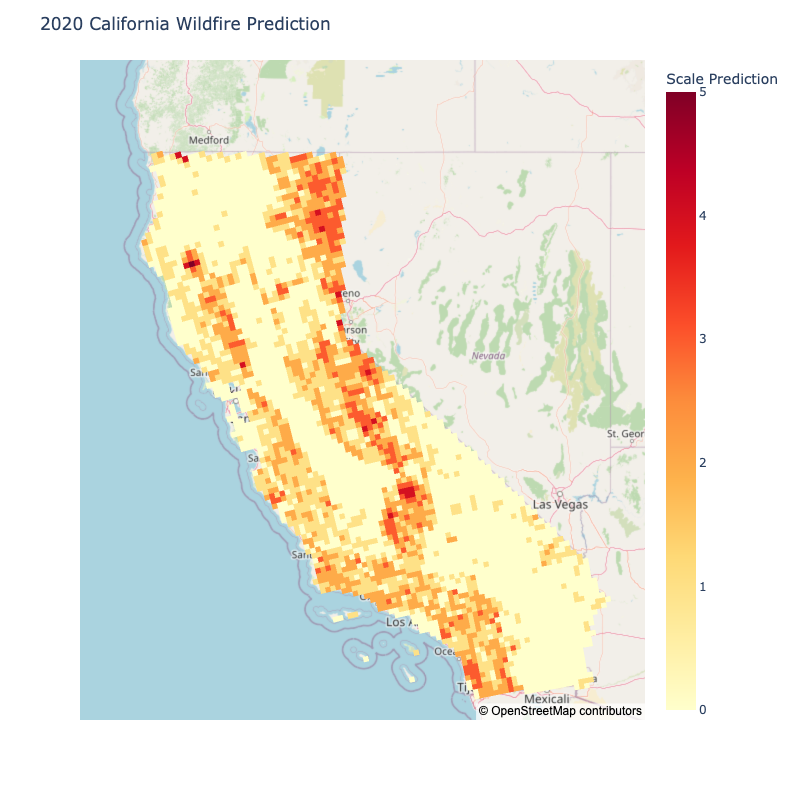

In [319]:
df = prediction_df.loc[prediction_df['year']==2020]
g = gpd.GeoSeries(df['location'])
# df = wildfire_df.loc[wildfire_df['year']==2020,['category', 'location']]
# g = gpd.GeoSeries(df['location'])
poly_json = json.loads(g.to_json())
                                            

fig = px.choropleth_mapbox(df, geojson=poly_json, color=df.prediction,
                          locations=df.index, featureidkey='id',
                          color_continuous_scale='YlOrRd',
                           zoom=5,
                          center={'lat': 38, 'lon': -119.5},
                          )
fig.update_layout(width=800, height=800,
                   mapbox_style="open-street-map",
                  coloraxis_colorbar={
                      'title':'Scale Prediction',
                  },
                  title = '2020 California Wildfire Prediction'
                 )
fig.update_traces(marker_line_width=0)
fig.show(renderer='png', height=800, width=800)

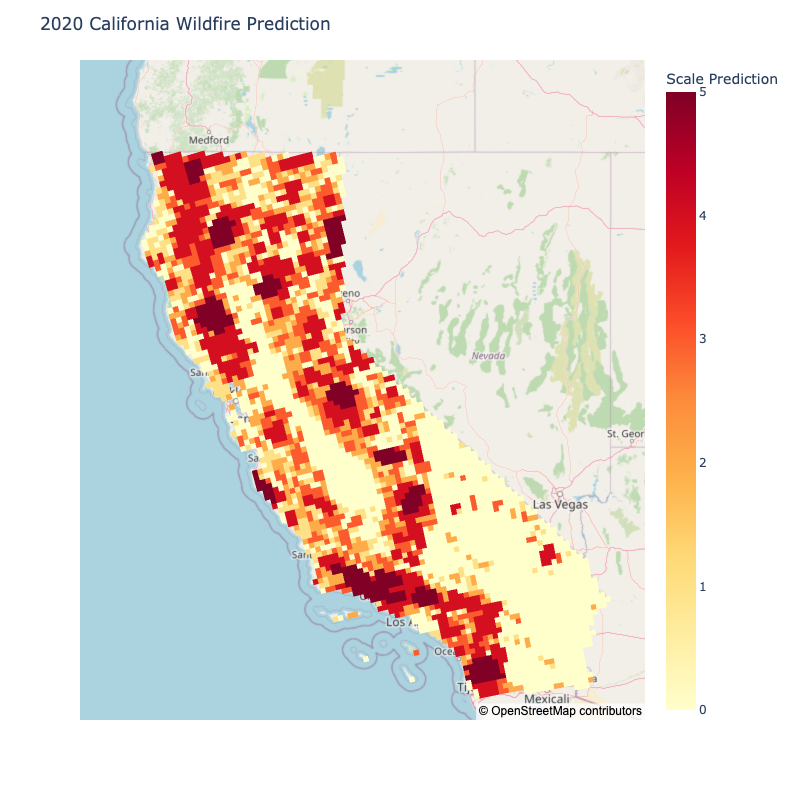

In [42]:
# df = wildfire_df.loc[wildfire_df['year']==2020]
df = wildfire_df.loc[(test_df['year']==2020)&(test_df['month']==7)]
# df = wildfire_df.loc[wildfire_df['category']>=3]
column = '20_year_history'
g = gpd.GeoSeries(df['location'])
# df = wildfire_df.loc[wildfire_df['year']==2020,['category', 'location']]
# g = gpd.GeoSeries(df['location'])
poly_json = json.loads(g.to_json())
                                            

fig = px.choropleth_mapbox(df, geojson=poly_json, color=df[column],
                          locations=df.index, featureidkey='id',
                          color_continuous_scale='YlOrRd',
                           zoom=5,
                          center={'lat': 38, 'lon': -119.5},
                          )
fig.update_layout(width=800, height=800,
                   mapbox_style="open-street-map",
                  coloraxis_colorbar={
                      'title':'Scale Prediction',
                  },
                  title = '2020 California Wildfire Prediction'
                 )
fig.update_traces(marker_line_width=0)
fig.show(renderer='png', height=800, width=800)

## Monthly Predictions

In [36]:
prediction_df = wildfire_df.dropna().loc[wildfire_df['year']>=2016][['year', 'month', 'x', 'y', 'lon', 'lat','location', 'category']]

In [39]:
wildfire_train_df = wildfire_df.dropna().loc[wildfire_df['year']<2016].drop(columns=['x', 'y','scale', 'acres', 'location'])
wildfire_test_df = wildfire_df.dropna().loc[wildfire_df['year']>=2016].drop(columns=['x', 'y','scale', 'acres', 'location'])

# train_x_resample, train_y_resample = SVMSMOTE().fit_resample(wildfire_train_df.drop(columns='category'), wildfire_train_df['category'])
train_x_resample_df, train_y_resample_df = RandomOverSampler(random_state=20).fit_resample(wildfire_train_df.drop(columns='category'), wildfire_train_df['category'])

test_x_df = wildfire_test_df.drop(columns='category')
test_y_df = wildfire_test_df['category']
train_x_resample_df

,year,month,lon,lat,tmax,tmin,vp,swe,prcp,vegetation,1_year_history,5_year_history,10_year_history,20_year_history
0,2001,1,-124.219872,40.178730,12.547097,5.222581,893.403198,0.0,204.190002,0.879405,0,0,0,3
1,2001,2,-124.219872,40.178730,11.294286,4.716786,862.440002,0.0,204.919998,0.854459,0,0,0,3
2,2001,3,-124.219872,40.178730,14.709678,6.734516,992.103210,0.0,72.989998,0.820015,0,0,0,3
3,2001,4,-124.219872,40.178730,13.413000,5.023334,883.905640,0.0,100.510002,0.849320,0,0,0,3
4,2001,5,-124.219872,40.178730,20.447420,9.984516,1235.278076,0.0,28.719999,0.829482,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029115,2009,9,-118.350273,34.502739,33.629333,16.760334,731.956665,0.0,0.000000,0.388233,0,3,3,3
4029116,2007,10,-117.184021,33.090462,24.742903,12.464193,553.361633,0.0,8.740000,0.445759,0,0,3,3
4029117,2012,8,-120.220421,40.816380,31.609676,10.975162,490.358063,0.0,0.000000,0.344454,0,1,3,3
4029118,2015,10,-118.645683,36.849838,12.751935,1.674516,410.207092,0.0,60.259998,0.548627,1,1,3,3


In [40]:
lon_min = min(train_x_resample_df['lon'].min(), test_x_df['lon'].min())
lon_max = max(train_x_resample_df['lon'].max(), test_x_df['lon'].max())
lat_min = min(train_x_resample_df['lat'].min(), test_x_df['lat'].min())
lat_max = max(train_x_resample_df['lat'].max(), test_x_df['lat'].max())
tmax_min = min(train_x_resample_df['tmax'].min().min(), test_x_df['tmax'].min().min())
tmax_max = max(train_x_resample_df['tmax'].max().max(), test_x_df['tmax'].max().max())
tmin_min = min(train_x_resample_df['tmin'].min().min(), test_x_df['tmin'].min().min())
tmin_max = max(train_x_resample_df['tmin'].max().max(), test_x_df['tmin'].max().max())
vp_min = min(train_x_resample_df['vp'].min().min(), test_x_df['vp'].min().min())
vp_max = max(train_x_resample_df['vp'].max().max(), test_x_df['vp'].max().max())
swe_min = min(train_x_resample_df['swe'].min().min(), test_x_df['swe'].min().min())
swe_max = max(train_x_resample_df['swe'].max().max(), test_x_df['swe'].max().max())
prcp_min = min(train_x_resample_df['prcp'].min().min(), test_x_df['prcp'].min().min())
prcp_max = max(train_x_resample_df['prcp'].max().max(), test_x_df['prcp'].max().max())
veg_min = min(train_x_resample_df['vegetation'].min().min(), test_x_df['vegetation'].min().min())
veg_max = max(train_x_resample_df['vegetation'].max().max(), test_x_df['vegetation'].max().max())
one_year_min = min(train_x_resample_df['1_year_history'].min().min(), test_x_df['1_year_history'].min())
one_year_max = max(train_x_resample_df['1_year_history'].max().max(), test_x_df['1_year_history'].max())
five_year_min = min(train_x_resample_df['5_year_history'].min().min(), test_x_df['5_year_history'].min())
five_year_max = max(train_x_resample_df['5_year_history'].max().max(), test_x_df['5_year_history'].max())
ten_year_min = min(train_x_resample_df['10_year_history'].min().min(), test_x_df['10_year_history'].min())
ten_year_max = max(train_x_resample_df['10_year_history'].max().max(), test_x_df['10_year_history'].max())
twenty_year_min = min(train_x_resample_df['20_year_history'].min().min(), test_x_df['20_year_history'].min())
twenty_year_max = max(train_x_resample_df['20_year_history'].max().max(), test_x_df['20_year_history'].max())

In [41]:
#Predictor Training Data
#=======================
x_train_raw = tf.convert_to_tensor(train_x_resample_df.drop(columns=['year']))

month_one_hot = tf.one_hot(tf.cast(x_train_raw[:, 0], tf.int32)-1, 12)
lon_norm = tf.cast(tf.reshape((x_train_raw[:, 1] - lon_min) / (lon_max - lon_min), [-1,1]), tf.float32)
lat_norm = tf.cast(tf.reshape((x_train_raw[:, 2] - lat_min) / (lat_max - lat_min), [-1,1]), tf.float32)
tmax_norm = tf.cast(tf.reshape((x_train_raw[:,3] - tmax_min) / (tmax_max-tmax_min), [-1,1]), tf.float32)
tmin_norm = tf.cast(tf.reshape((x_train_raw[:,4] - tmin_min) / (tmin_max-tmin_min), [-1,1]), tf.float32)
vp_norm = tf.cast(tf.reshape((x_train_raw[:,5] - vp_min) / (vp_max-vp_min), [-1,1]), tf.float32)
swe_norm = tf.cast(tf.reshape((x_train_raw[:,6] - swe_min) / (swe_max-swe_min), [-1,1]), tf.float32)
prcp_norm = tf.cast(tf.reshape((x_train_raw[:,7] - prcp_min) / (prcp_max-prcp_min), [-1,1]), tf.float32)
vegetation_norm = tf.cast(tf.reshape(x_train_raw[:,8], [-1,1]), tf.float32)
one_year_one_hot = tf.one_hot(tf.cast(x_train_raw[:,9], tf.int32), 6)
five_year_one_hot = tf.one_hot(tf.cast(x_train_raw[:,10], tf.int32), 6)
ten_year_one_hot = tf.one_hot(tf.cast(x_train_raw[:,11], tf.int32), 6)
twenty_year_one_hot = tf.one_hot(tf.cast(x_train_raw[:,12], tf.int32), 6)

x_train = tf.concat([month_one_hot, lon_norm, lat_norm, tmax_norm, tmin_norm, vp_norm, swe_norm, prcp_norm, vegetation_norm, one_year_one_hot, five_year_one_hot, ten_year_one_hot, twenty_year_one_hot], 1)
x_train

<tf.Tensor: shape=(4029120, 44), dtype=float32, numpy=
array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [42]:
#Predictor Testing Data
#======================
x_test_raw = tf.convert_to_tensor(test_x_df.drop(columns=['year']))

month_one_hot = tf.one_hot(tf.cast(x_test_raw[:, 0], tf.int32)-1, 12)
lon_norm = tf.cast(tf.reshape((x_test_raw[:, 1] - lon_min) / (lon_max - lon_min), [-1,1]), tf.float32)
lat_norm = tf.cast(tf.reshape((x_test_raw[:, 2] - lat_min) / (lat_max - lat_min), [-1,1]), tf.float32)
tmax_norm = tf.cast(tf.reshape((x_test_raw[:,3] - tmax_min) / (tmax_max-tmax_min), [-1,1]), tf.float32)
tmin_norm = tf.cast(tf.reshape((x_test_raw[:,4] - tmin_min) / (tmin_max-tmin_min), [-1,1]), tf.float32)
vp_norm = tf.cast(tf.reshape((x_test_raw[:,5] - vp_min) / (vp_max-vp_min), [-1,1]), tf.float32)
swe_norm = tf.cast(tf.reshape((x_test_raw[:,6] - swe_min) / (swe_max-swe_min), [-1,1]), tf.float32)
prcp_norm = tf.cast(tf.reshape((x_test_raw[:,7] - prcp_min) / (prcp_max-prcp_min), [-1,1]), tf.float32)
vegetation_norm = tf.cast(tf.reshape(x_test_raw[:,8], [-1,1]), tf.float32)
one_year_one_hot = tf.one_hot(tf.cast(x_test_raw[:,9], tf.int32), 6)
five_year_one_hot = tf.one_hot(tf.cast(x_test_raw[:,10], tf.int32), 6)
ten_year_one_hot = tf.one_hot(tf.cast(x_test_raw[:,11], tf.int32), 6)
twenty_year_one_hot = tf.one_hot(tf.cast(x_test_raw[:,12], tf.int32), 6)

x_test = tf.concat([month_one_hot, lon_norm, lat_norm, tmax_norm, tmin_norm, vp_norm, swe_norm, prcp_norm, vegetation_norm, one_year_one_hot, five_year_one_hot, ten_year_one_hot, twenty_year_one_hot], 1)
x_test

<tf.Tensor: shape=(226559, 44), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [43]:
y_train = tf.convert_to_tensor(train_y_resample_df)
y_train = tf.one_hot(y_train, 6)
y_test = tf.convert_to_tensor(test_y_df)
y_test = tf.one_hot(y_test, 6)
y_train, y_test

(<tf.Tensor: shape=(4029120, 6), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(226559, 6), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]], dtype=float32)>)

In [44]:
#Ordinal Regression Layer
#========================
class Ordinal(tf.keras.Model):
    def __init__(self, num_classes):
        super(Ordinal, self).__init__(name='')
        
        omega_init = tf.range(0., num_classes-1, dtype='float32')
        self.omega = tf.Variable(tf.expand_dims(omega_init, axis=0))
        
        const_zero = tf.zeros((1,1),dtype='float32')
        self.const_zero = tf.constant(const_zero)
        
        b_init = tf.zeros(1, dtype='float32')
        self.b = tf.Variable(b_init)
        
    def call(self, input_X, training=False):
        omega_diff = tf.nn.relu(self.omega[:,1:]-self.omega[:,:-1]) + 1
        
        theta_pdf = tf.concat([self.const_zero, omega_diff], axis=1)
        
        linear = tf.cumsum(theta_pdf, axis=1) - input_X - self.b*self.b
        
        cumulative_proba = tf.nn.sigmoid(linear)
        
        proba_list = [cumulative_proba[:, :1],
                     cumulative_proba[:,1:]-cumulative_proba[:,:-1],
                     1-cumulative_proba[:,-1:]]
        proba = tf.keras.layers.Concatenate(axis=1)(proba_list)
        
        return proba

In [79]:
#Neural Network and Training (Classification)
#============================================
Results_df = pd.DataFrame(columns=['learning rate', 'epochs', 'batch size', 'hidden layers', 'neurons', 'dropout', 'regularization',
                                   'accuracy', 'occurence recall', 'occurence precision', 'large fire recall', 'large fire precision', 'scale accuracy', 'scale relaxed accuracy'])
learning_rate = [0.005,0.05]
num_epochs = [50,200]
batch_size = [1000,50000]
num_hidden_layers = [2,3]
num_neurons = [50,200]
dropout_val = [0,0.1]
regularization_val = [0,0.0001]

num_iter = 0
for lr in learning_rate:
    for epoch in num_epochs:
        for batch in batch_size:
            for hidden_layer in num_hidden_layers:
                for neuron in num_neurons:
                    for dropout in dropout_val:
                        for l2 in regularization_val:
                            if num_iter <=0:
                                inputs = keras.layers.Input(shape=x_train.shape[1:])
                                x = keras.layers.BatchNormalization()(inputs)
                                for layer in range(hidden_layer):
                                    x = keras.layers.Dense(neuron, kernel_regularizer=keras.regularizers.l2(l2), activation='elu', kernel_initializer='he_normal')(x)
                                    x = keras.layers.Dropout(dropout)(x)
                                    x = keras.layers.BatchNormalization()(x)
                                x = keras.layers.Dense(1, activation='linear')(x)
                                outputs = Ordinal(6)(x)
                                model = keras.Model(inputs=[inputs], outputs=[outputs])

                                metrics = [
                                    'accuracy',
                                    keras.metrics.Recall(class_id=1, name='class_1_recall'),
                                    keras.metrics.Recall(class_id=2, name='class_2_recall'),
                                    keras.metrics.Recall(class_id=3, name='class_3_recall'),
                                    keras.metrics.Recall(class_id=4, name='class_4_recall'),
                                    keras.metrics.Recall(class_id=5, name='class_5_recall')

                                ]

                                model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                                              #optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.99),
                                              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),#, label_smoothing=0.1),
                                              metrics=metrics)

                                history = model.fit(
                                    x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=batch, shuffle=True)
                            num_iter+=1

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4030/4030 [==============================] - ETA: 0s - loss: 1.5360 - accuracy: 0.5250 - class_1_recall: 0.1996 - class_2_recall: 0.2735 - class_3_recall: 0.3021 - class_4_recall: 0.5864 - class_5_recall: 0.7539WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2f33c8e50> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4030/4030 [==============================] - 44s 8ms/step - loss: 1.5359 - accuracy: 0.5250 - class_1_recall: 0.1997 - class_2_recall: 0.2736 - class_3_recall: 0.3022 - class_4_recall: 0.5864 - class_5_recall: 0.7540 - val_loss: 1.3814 - val_accuracy: 0.6489 - val_class_1_recall: 0.2317 - val_class_2_recall: 0.2725 - val_class_3_recall: 0.2442 - val_class_4_recall: 0.2147 - val_class_5_recall: 0.0513
Epoch 2/50
4030/4030 [==============================] - 13s 3ms/step - loss: 1.3848 - accuracy: 0.6816 - class_1_recall: 0.4563 - class_2_recall: 0.6370 - class_3_recall: 0.7060 - class_4_recall: 0.7798 - class_5_recall: 0.8627 - val_loss: 1.3948 - val_accuracy: 0.6390 - val_cla

In [80]:
y_pred = np.argmax(model.predict(x_test), axis=1)
prediction_df['prediction'] = y_pred

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [81]:
count = 0
correct = 0
prediction_count = {}
for prediction in range(0,6):
    prediction_count[prediction] = 0
occurence_tp = 0
occurence_fn = 0
occurence_fp = 0
scale_tp = 0
scale_fn = 0
scale_fp = 0
relaxed_scale_tp = 0
relaxed_scale_fn = 0
relaxed_scale_fp = 0
large_fire_tp = 0
large_fire_fn = 0
large_fire_fp = 0

for prediction in prediction_df.to_dict('records'):
    prediction_count[prediction['prediction']]+=1
    
    if prediction['category']==prediction['prediction']:
        correct +=1
    count +=1
    
    if prediction['category']>0:
        if prediction['prediction']>0:
            occurence_tp+=1
        else:
            occurence_fn+=1
            
        if prediction['category']==prediction['prediction']:
            scale_tp+=1
        else:
            scale_fn+=1
        
        if (abs(prediction['category']-prediction['prediction'])<=1) and (prediction['prediction']!=0):
            relaxed_scale_tp+=1
        else:
            relaxed_scale_fn+=1      
    else:
        if prediction['prediction']>0:
            occurence_fp+=1
            
    if (prediction['category']==3) or (prediction['category']==4) or (prediction['category']==5):
        if (prediction['prediction']==3) or (prediction['prediction']==4) or (prediction['prediction']==5):
            large_fire_tp+=1
        else:
            large_fire_fn+=1
    else:
        if (prediction['prediction']==3) or (prediction['prediction']==4) or (prediction['prediction']==5):
            large_fire_fp+=1
    
    
    
            
            
print(prediction_count)      
print('accuracy:', correct/count)
print('occurence recall:', occurence_tp/(occurence_tp+occurence_fn))
print('occurence precision:', occurence_tp/(occurence_tp+occurence_fp))
print('large fire recall:', large_fire_tp/(large_fire_tp+large_fire_fn))
print('large fire precision:', large_fire_tp/(large_fire_tp+large_fire_fp))
print('scale accuracy:', scale_tp/(scale_tp+scale_fn))
print('scale relaxed accuracy:', relaxed_scale_tp/(relaxed_scale_tp+relaxed_scale_fn))

{0: 145165, 1: 24038, 2: 21897, 3: 18961, 4: 13116, 5: 3382}
accuracy: 0.6421550236362272
occurence recall: 0.8700990099009901
occurence precision: 0.05398432316878394
large fire recall: 0.5369422092172641
large fire precision: 0.04139992667587918
scale accuracy: 0.19346534653465347
scale relaxed accuracy: 0.501980198019802


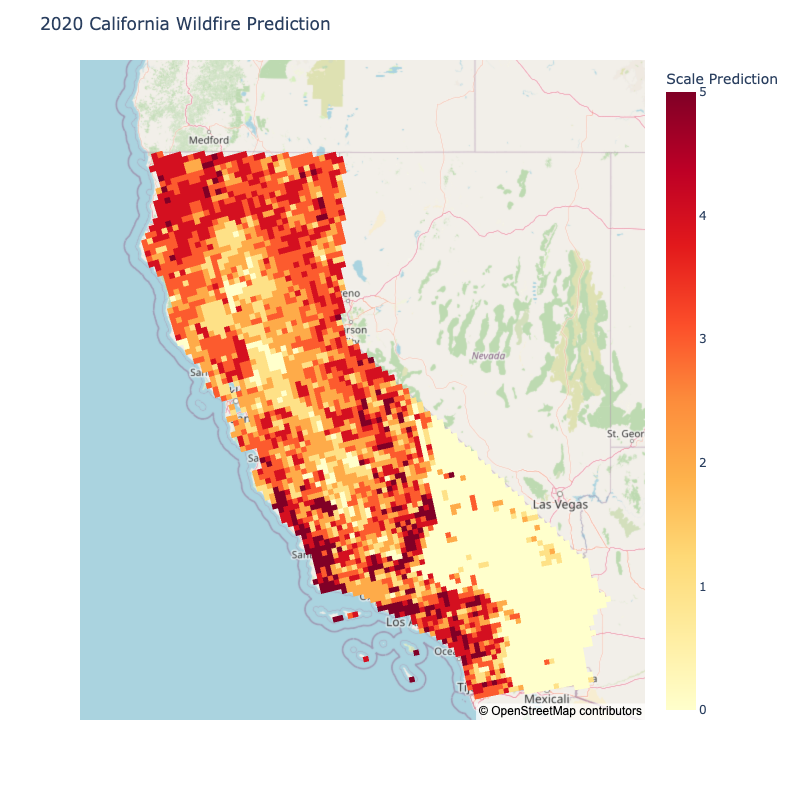

In [172]:
df = prediction_df.loc[(prediction_df['year']==2019) & (prediction_df['month']==8)]
g = gpd.GeoSeries(df['location'])
# df = wildfire_df.loc[wildfire_df['year']==2020,['category', 'location']]
# g = gpd.GeoSeries(df['location'])
poly_json = json.loads(g.to_json())
                                            

fig = px.choropleth_mapbox(df, geojson=poly_json, color=df.prediction,
                          locations=df.index, featureidkey='id',
                          color_continuous_scale='YlOrRd',
                           zoom=5,
                          center={'lat': 38, 'lon': -119.5},
                          )
fig.update_layout(width=800, height=800,
                   mapbox_style="open-street-map",
                  coloraxis_colorbar={
                      'title':'Scale Prediction',
                  },
                  title = '2020 California Wildfire Prediction'
                 )
fig.update_traces(marker_line_width=0)
fig.show(renderer='png', height=800, width=800)

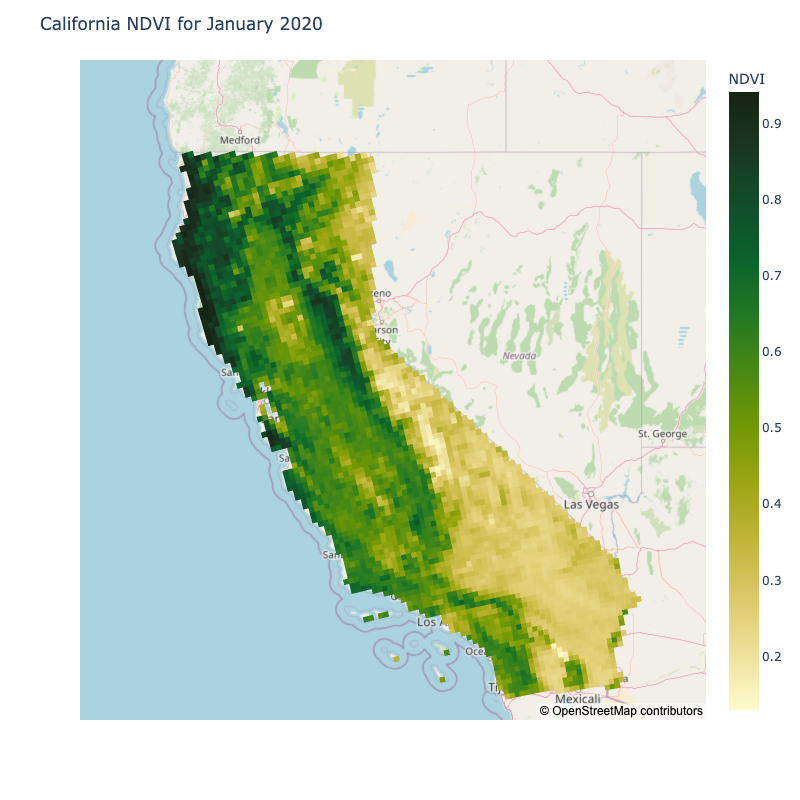

In [188]:
df = wildfire_df.loc[(wildfire_df['year']==2020) & (wildfire_df['month']==1)]
g = gpd.GeoSeries(df['location'])
poly_json = json.loads(g.to_json())
                                            

fig = px.choropleth_mapbox(df, geojson=poly_json, color=df.vegetation,
                          locations=df.index, featureidkey='id',
                          color_continuous_scale='speed',
                           zoom=5,
                          center={'lat': 38, 'lon': -119.5},
                          )
fig.update_layout(width=800, height=800,
                   mapbox_style="open-street-map",
                  coloraxis_colorbar={
                      'title':'NDVI',
                  },
                  title = 'California NDVI for January 2020'
                 )
fig.update_traces(marker_line_width=0)
fig.show(renderer='png', height=800, width=800)
fig.write_image('../Figures/california_2020_vegetation.png')

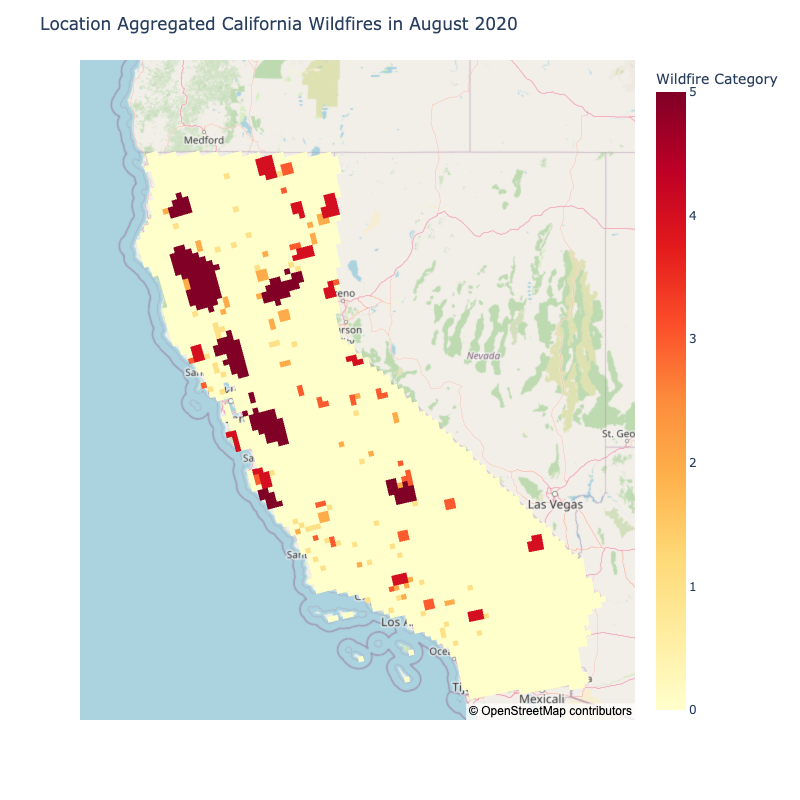

In [34]:
df = df.loc[(df['year']==2020) & (df['month']==8)]
g = gpd.GeoSeries(df['location'])
poly_json = json.loads(g.to_json())
                                            

fig = px.choropleth_mapbox(df, geojson=poly_json, color=df.category,
                          locations=df.index, featureidkey='id',
                          color_continuous_scale='YlOrRd',
                           zoom=5,
                          center={'lat': 38, 'lon': -119.5},
                          )
fig.update_layout(width=800, height=800,
                   mapbox_style="open-street-map",
                  coloraxis_colorbar={
                      'title':'Wildfire Category',
                  },
                  title = 'Location Aggregated California Wildfires in August 2020'
                 )
fig.update_traces(marker_line_width=0)
fig.show(renderer='png', height=800, width=800)
fig.write_image('../Figures/california_8_2020_wildfires_category.png')

In [190]:
wildfire_df

,year,month,x,y,lon,lat,tmax,tmin,vp,swe,prcp,vegetation,acres,category,location,scale,1_year_history,5_year_history,10_year_history,20_year_history
0,2001,1,-1942.25,38.0,-124.219872,40.178730,12.547097,5.222581,893.403198,0.0,204.190002,0.879405,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
1,2001,2,-1942.25,38.0,-124.219872,40.178730,11.294286,4.716786,862.440002,0.0,204.919998,0.854459,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
2,2001,3,-1942.25,38.0,-124.219872,40.178730,14.709678,6.734516,992.103210,0.0,72.989998,0.820015,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
3,2001,4,-1942.25,38.0,-124.219872,40.178730,13.413000,5.023334,883.905640,0.0,100.510002,0.849320,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
4,2001,5,-1942.25,38.0,-124.219872,40.178730,20.447420,9.984516,1235.278076,0.0,28.719999,0.829482,0.0,0,POLYGON ((-124.2198715209961 40.17873001098633...,0.0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906235,2020,8,-1252.25,-762.0,-114.170769,34.329227,45.645805,28.420322,1548.209717,0.0,0.000000,0.291359,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906236,2020,9,-1252.25,-762.0,-114.170769,34.329227,41.957668,22.780333,1089.722656,0.0,0.000000,0.291136,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906237,2020,10,-1252.25,-762.0,-114.170769,34.329227,35.847420,15.839678,700.292603,0.0,0.000000,0.290580,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0
906238,2020,11,-1252.25,-762.0,-114.170769,34.329227,26.263334,8.921667,460.159332,0.0,0.000000,0.294397,0.0,0,"POLYGON ((-114.170768737793 34.32922744750977,...",0.0,0,0,0,0


(array([893041.,      0.,   4230.,      0.,   2480.,      0.,   2289.,
             0.,   2546.,   1654.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

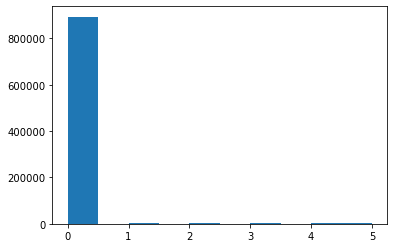

In [199]:
plt.hist(wildfire_df['category'])

In [ ]:
len(x_train)